In [1]:
%load_ext watermark


In [2]:
import os

from IPython.display import display
import pandas as pd
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-01-19T18:21:00.813458+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.5.0-1025-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

seaborn: 0.13.2
pandas : 2.2.3
polars : 1.9.0
teeplot: 1.2.0

Watermark: 2.4.3



In [4]:
teeplot_subdir = os.environ.get("NOTEBOOK_NAME", "2025-01-18-cpp-bench-memory")
teeplot_subdir


'2025-01-18-cpp-bench-memory'

## Prep Data


In [5]:
df = pl.concat(
    [
        pl.read_csv("https://osf.io/m6wne/download"),
        pl.read_csv("https://osf.io/sb4zw/download"),
    ],
)
df = (
    df.cast(
        {
            "memory_bytes": pl.Int32,
            "num_items": pl.Int32,
            "num_sites": pl.Int32,
            "duration_s": pl.Float64,
            "replicate": pl.Int32,
        },
    )
    .with_columns(
        duration_per_item_ns=(
            pl.col("duration_s") * 1_000_000_000 / pl.col("num_items")
        )
    )
    .with_columns(
        algorithm=pl.col("algo_name").map_elements(
            {
                "control_ring_algo": "control: ringbuf",
                "control_throwaway_algo": "control: discard",
                "dstream.steady_algo": "dstream steady",
                "dstream.stretched_algo": "dstream stretched",
                "dstream.tilted_algo": "dstream tilted",
                "naive_steady_algo": "naive steady",
                "zhao_steady_algo": "zhao steady",
            }.__getitem__,
            return_dtype=str,
        )
    )
)

display(df.describe()), display(df.head()), display(df.tail());


statistic,algo_name,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,duration_per_item_ns,algorithm
str,str,str,f64,f64,f64,f64,f64,f64,str
"""count""","""3360""","""3360""",3360.0,3360.0,3360.0,3360.0,3360.0,3360.0,"""3360"""
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""0"""
"""mean""",null,null,1743.142857,370000.0,1360.0,9.5,0.075369,253.472679,null
"""std""",null,null,4352.995669,447056.463983,1620.196674,5.76714,0.443729,856.892597,null
"""min""","""control_ring_algo""","""clang++""",12.0,10000.0,64.0,0.0,0.000019,1.8498,"""control: discard"""
"""25%""",null,null,36.0,10000.0,256.0,5.0,0.000185,1.9487,null
"""50%""",null,null,132.0,100000.0,1024.0,10.0,0.001077,4.57576,null
"""75%""",null,null,516.0,1e6,1024.0,14.0,0.00506,12.744677,null
"""max""","""zhao_steady_algo""","""g++""",16960.0,1e6,4096.0,19.0,4.109061,5265.7165,"""zhao steady"""


algo_name,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,duration_per_item_ns,algorithm
str,str,i32,i32,i32,i32,f64,f64,str
"""control_ring_algo""","""clang++""",12,10000,64,0,0.000019,1.8706,"""control: ringbuf"""
"""control_ring_algo""","""clang++""",12,10000,64,1,0.000019,1.8515,"""control: ringbuf"""
"""control_ring_algo""","""clang++""",12,10000,64,2,0.000019,1.8615,"""control: ringbuf"""
"""control_ring_algo""","""clang++""",12,10000,64,3,0.000019,1.8615,"""control: ringbuf"""
"""control_ring_algo""","""clang++""",12,10000,64,4,0.000019,1.8515,"""control: ringbuf"""


algo_name,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,duration_per_item_ns,algorithm
str,str,i32,i32,i32,i32,f64,f64,str
"""zhao_steady_algo""","""g++""",16960,1000000,4096,15,0.209289,209.288573,"""zhao steady"""
"""zhao_steady_algo""","""g++""",16960,1000000,4096,16,0.209329,209.328809,"""zhao steady"""
"""zhao_steady_algo""","""g++""",16960,1000000,4096,17,0.209349,209.348586,"""zhao steady"""
"""zhao_steady_algo""","""g++""",16960,1000000,4096,18,0.209307,209.307408,"""zhao steady"""
"""zhao_steady_algo""","""g++""",16960,1000000,4096,19,0.209077,209.076802,"""zhao steady"""


## Plot


## Memory Use


teeplots/2025-01-18-cpp-bench-memory/col=num-items+hue=algo-name+kind=line+palette=muted+viz=relplot+x=num-sites+y=memory-bytes+ext=.pdf
teeplots/2025-01-18-cpp-bench-memory/col=num-items+hue=algo-name+kind=line+palette=muted+viz=relplot+x=num-sites+y=memory-bytes+ext=.png


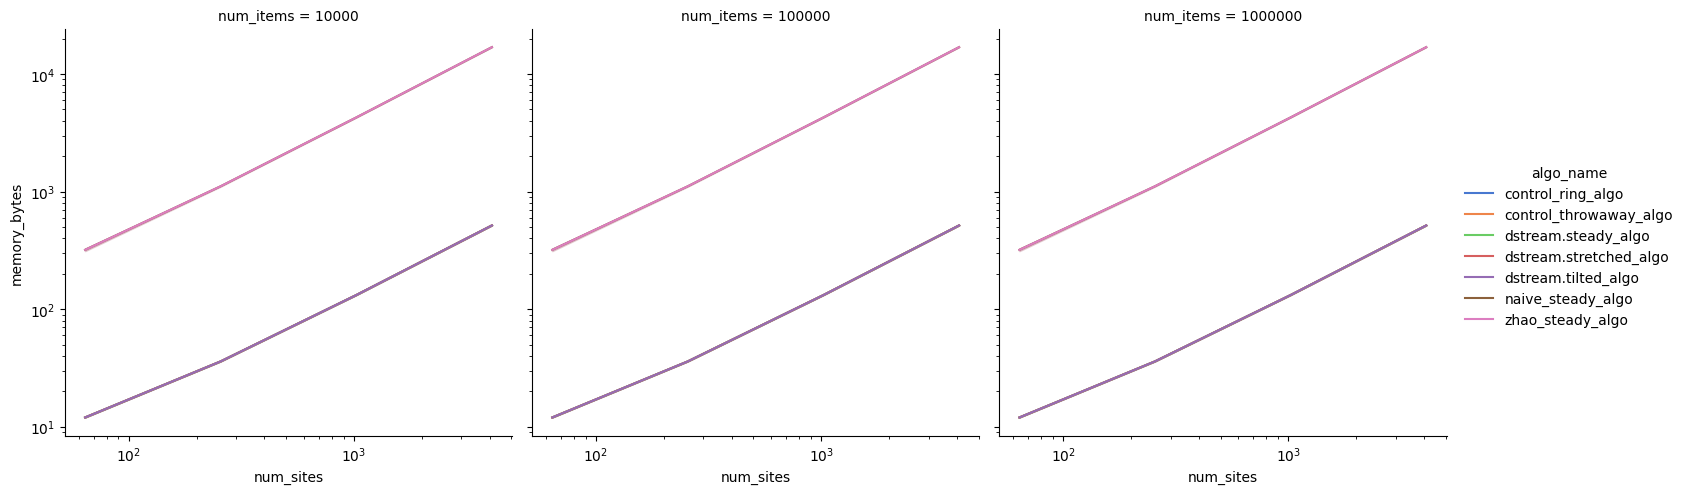

In [6]:
with tp.teed(
    sns.relplot,
    data=df,
    x="num_sites",
    y="memory_bytes",
    hue="algo_name",
    col="num_items",
    palette="muted",
    kind="line",
    errorbar=("pi", 100),
    teeplot_subdir=teeplot_subdir,
) as g:
    g.set(xscale="log", yscale="log")


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:44: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set(**kwargs)


teeplots/2025-01-18-cpp-bench-memory/hue=strategy+kind=bar+palette=set2+viz=catplot+x=num-sites+y=memory-bytes+ext=.pdf
teeplots/2025-01-18-cpp-bench-memory/hue=strategy+kind=bar+palette=set2+viz=catplot+x=num-sites+y=memory-bytes+ext=.png


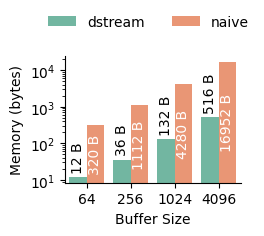

In [7]:
# Plot speedup
with tp.teed(
    sns.catplot,
    data=df.filter(
        pl.col("algo_name").is_in(
            [
                "dstream.steady_algo",
                "naive_steady_algo",
            ],
        ),
    ).with_columns(
        strategy=pl.col("algo_name").map_elements(
            {
                "dstream.steady_algo": "dstream",
                "naive_steady_algo": "naive",
            }.__getitem__,
            return_dtype=str,
        ),
    ),
    x="num_sites",
    y="memory_bytes",
    hue="strategy",
    kind="bar",
    aspect=1.5,
    height=2,
    palette="Set2",
    teeplot_subdir=teeplot_subdir,
) as g:
    g.set(yscale="log")
    g.set(ylim=(0, None))
    g.set_xlabels("Buffer Size")
    g.set_ylabels("Memory (bytes)")
    for ax in g.axes.flat:
        ax.bar_label(
            ax.containers[0],
            fmt="%d B",
            label_type="edge",
            rotation=90,
            padding=3,
        )
        ax.bar_label(
            ax.containers[1],
            fmt="%d B",
            label_type="center",
            rotation=90,
            color="white",
        )
    sns.move_legend(
        g,
        "lower center",
        bbox_to_anchor=(0.5, 1),
        ncol=3,
        frameon=False,
        title=None,
    )


## relative memory savings


,num_sites,num_items,replicate,memory_savings
0,256,370000.0,9.5,30.888889
1,1024,370000.0,9.5,32.424242
2,4096,370000.0,9.5,32.852713
3,64,370000.0,9.5,26.666667


teeplots/2025-01-18-cpp-bench-memory/kind=bar+viz=catplot+x=num-sites+y=memory-savings+ext=.pdf
teeplots/2025-01-18-cpp-bench-memory/kind=bar+viz=catplot+x=num-sites+y=memory-savings+ext=.png


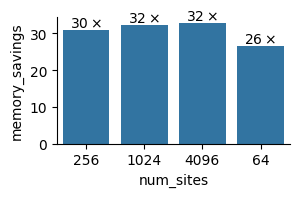

In [8]:
df_memory_savings = (
    df.filter(
        pl.col("algo_name").is_in(["dstream.steady_algo", "naive_steady_algo"])
    )
    .group_by(["num_items", "num_sites", "replicate"])
    .agg(
        memory_savings=(
            pl.col("memory_bytes")
            .filter(pl.col("algo_name") == "naive_steady_algo")
            .mean()
            / pl.col("memory_bytes")
            .filter(pl.col("algo_name") == "dstream.steady_algo")
            .mean()
        )
    )
)
with pd.option_context("display.max_columns", None):
    with pd.option_context("display.max_rows", None):
        display(df_memory_savings.group_by(["num_sites"]).mean().to_pandas())


# Plot savings
with tp.teed(
    sns.catplot,
    data=df_memory_savings.cast({"num_sites": str}),
    x="num_sites",
    y="memory_savings",
    kind="bar",
    aspect=1.5,
    height=2,
    teeplot_subdir=teeplot_subdir,
) as g:
    g.set(ylim=(0, None))
    for ax in g.axes.flat:
        ax.bar_label(ax.containers[0], fmt="$%d\\times$")


## absolute memory savings


teeplots/2025-01-18-cpp-bench-memory/kind=bar+viz=catplot+x=num-sites+y=memory-savings+ext=.pdf
teeplots/2025-01-18-cpp-bench-memory/kind=bar+viz=catplot+x=num-sites+y=memory-savings+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-memory/kind=bar+viz=catplot+x=num-sites+y=memory-savings+ext=.pdf, overwriting it
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-memory/kind=bar+viz=catplot+x=num-sites+y=memory-savings+ext=.png, overwriting it
  warnings.warn(


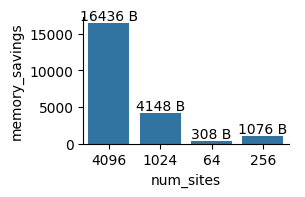

In [9]:
df_memory_savings = (
    df.filter(
        pl.col("algo_name").is_in(["dstream.steady_algo", "naive_steady_algo"])
    )
    .group_by(["num_items", "num_sites", "replicate"])
    .agg(
        memory_savings=(
            pl.col("memory_bytes")
            .filter(pl.col("algo_name") == "naive_steady_algo")
            .mean()
            - pl.col("memory_bytes")
            .filter(pl.col("algo_name") == "dstream.steady_algo")
            .mean()
        )
    )
)

# Plot savings
with tp.teed(
    sns.catplot,
    data=df_memory_savings.cast({"num_sites": str}),
    x="num_sites",
    y="memory_savings",
    kind="bar",
    aspect=1.5,
    height=2,
    teeplot_subdir=teeplot_subdir,
) as g:
    g.set(ylim=(0, None))
    for ax in g.axes.flat:
        ax.bar_label(ax.containers[0], fmt="%d B")
